# Building powerful image classification models using very little data

https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import os
import datetime as dt
import numpy as np
import pandas as pd

In [4]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [5]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

In [6]:
from keras import backend as K
K.set_image_dim_ordering('th')

### Image data generation from transformations

In [7]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [8]:
img = load_img('data/train/cats/cat.0.jpg')

In [9]:
x = img_to_array(img)
x = x.reshape((1,) + x.shape)

In [10]:
i = 0
for batch in datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='cat', save_format='jpeg'):
    i += 1
    if i > 20:
        break

### Build small convnet

In [11]:
model = Sequential()

In [12]:
# input conv2d layer layer 32 filters, 3x3 kernel
model.add(Conv2D(32, (3, 3), input_shape=(3, 150, 150)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# conv2d layer 32 filters, 3x3 kernel
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# conv2d layer 64 filters, 3x3 kernel
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

In [13]:
# this converts our 3D feature maps to 1D feature vectors
model.add(Flatten())

# fully connected layer, 64 outputs
model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dropout(0.5))

# output layer and sigmoid activation
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [14]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

### Set up data generators

In [15]:
batch_size = 16
nb_train_samples = 4000
nb_validation_samples = 800
epochs = 50

In [16]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

In [17]:
# this is the augmentation configuration we will use for testing (only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

In [18]:
# this is a generator that will read pictures found in subfolders of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        'data/train',            # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='binary')     # since we use binary_crossentropy loss, we need binary labels

Found 4000 images belonging to 2 classes.


In [19]:
# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        'data/validation',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')

Found 800 images belonging to 2 classes.


### Train model

In [20]:
model_history = model.fit_generator(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=nb_validation_samples // batch_size)
model.save_weights('first_try.h5')

Epoch 1/50
250/250 [==============================] - 294s 1s/step - loss: 0.6985 - acc: 0.5507 - val_loss: 0.6664 - val_acc: 0.5563
Epoch 2/50
250/250 [==============================] - 286s 1s/step - loss: 0.6562 - acc: 0.6295 - val_loss: 0.5731 - val_acc: 0.7200
Epoch 3/50
250/250 [==============================] - 278s 1s/step - loss: 0.6117 - acc: 0.6780 - val_loss: 0.5537 - val_acc: 0.7063
Epoch 4/50
250/250 [==============================] - 275s 1s/step - loss: 0.5957 - acc: 0.6925 - val_loss: 0.5648 - val_acc: 0.7100
Epoch 5/50
250/250 [==============================] - 276s 1s/step - loss: 0.5760 - acc: 0.7080 - val_loss: 0.5213 - val_acc: 0.7388
Epoch 6/50
250/250 [==============================] - 279s 1s/step - loss: 0.5624 - acc: 0.7275 - val_loss: 0.5274 - val_acc: 0.7425
Epoch 7/50
250/250 [==============================] - 278s 1s/step - loss: 0.5455 - acc: 0.7330 - val_loss: 0.7231 - val_acc: 0.6162
Epoch 8/50
250/250 [==============================] - 276s 1s/step - 

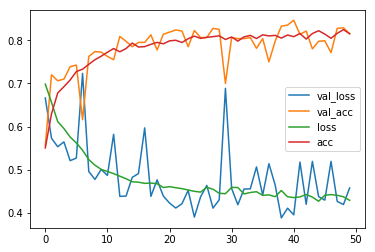

In [21]:
pd.DataFrame(model_history.history).plot();